Imports of all the libraries needed

In [1]:
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import roc_curve, auc


Spark session and definition of the DataFrame schema and printing of some of them

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Exercise_3").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(spark.sparkContext)

DATASET="/content/drive/MyDrive/flights_sample_3m.csv"

# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("FL_DATE", StringType(), nullable=True),
    StructField("AIRLINE", StringType(), nullable=True),
    StructField("AIRLINE_DOT", StringType(), nullable=True),
    StructField("AIRLINE_CODE", StringType(), nullable=True),
    StructField("DOT_CODE", LongType(), nullable=True),
    StructField("FL_NUMBER", LongType(), nullable=True),
    StructField("ORIGIN", StringType(), nullable=True),
    StructField("ORIGIN_CITY", StringType(), nullable=True),
    StructField("DEST", StringType(), nullable=True),
    StructField("DEST_CITY", StringType(), nullable=True),
    StructField("CRS_DEP_TIME", LongType(), nullable=True),
    StructField("DEP_TIME", DoubleType(), nullable=True),
    StructField("DEP_DELAY", DoubleType(), nullable=True),
    StructField("TAXI_OUT", DoubleType(), nullable=True),
    StructField("WHEELS_OFF", DoubleType(), nullable=True),
    StructField("WHEELS_ON", DoubleType(), nullable=True),
    StructField("TAXI_IN", DoubleType(), nullable=True),
    StructField("CRS_ARR_TIME", LongType(), nullable=True),
    StructField("ARR_TIME", DoubleType(), nullable=True),
    StructField("ARR_DELAY", DoubleType(), nullable=True),
    StructField("CANCELLED", DoubleType(), nullable=True),
    StructField("CANCELLATION_CODE", StringType(), nullable=True),
    StructField("DIVERTED", DoubleType(), nullable=True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), nullable=True),
    StructField("ELAPSED_TIME", DoubleType(), nullable=True),
    StructField("AIR_TIME", DoubleType(), nullable=True),
    StructField("DISTANCE", DoubleType(), nullable=True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), nullable=True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), nullable=True),
    StructField("DELAY_DUE_NAS", DoubleType(), nullable=True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), nullable=True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), nullable=True),]
)

dataset_df = spark.read.csv(path=DATASET, header=True, schema=schema).cache()
dataset_df.show(2)
dataset_df.printSchema()
dataset_df.dtypes

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+-----------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|   FL_DATE|             AIRLINE|         AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|        ORIGIN_CITY|DEST|  DEST_CITY|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+--------------------+--------------------+------------+--------+---------+------+-------------------+----+-----------+------------+--------+---------+--------+-------

[('FL_DATE', 'string'),
 ('AIRLINE', 'string'),
 ('AIRLINE_DOT', 'string'),
 ('AIRLINE_CODE', 'string'),
 ('DOT_CODE', 'bigint'),
 ('FL_NUMBER', 'bigint'),
 ('ORIGIN', 'string'),
 ('ORIGIN_CITY', 'string'),
 ('DEST', 'string'),
 ('DEST_CITY', 'string'),
 ('CRS_DEP_TIME', 'bigint'),
 ('DEP_TIME', 'double'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('WHEELS_OFF', 'double'),
 ('WHEELS_ON', 'double'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'bigint'),
 ('ARR_TIME', 'double'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'double'),
 ('CANCELLATION_CODE', 'string'),
 ('DIVERTED', 'double'),
 ('CRS_ELAPSED_TIME', 'double'),
 ('ELAPSED_TIME', 'double'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('DELAY_DUE_CARRIER', 'double'),
 ('DELAY_DUE_WEATHER', 'double'),
 ('DELAY_DUE_NAS', 'double'),
 ('DELAY_DUE_SECURITY', 'double'),
 ('DELAY_DUE_LATE_AIRCRAFT', 'double')]

Base statistics and outliers that are described by the mean, the standard deviation the max and the min.

In [3]:
stats_df = dataset_df.describe()

stats_col = [
    "DEP_DELAY", "TAXI_OUT", "CRS_ELAPSED_TIME", "ELAPSED_TIME",
    "TAXI_IN", "ARR_DELAY", "AIR_TIME", "DISTANCE"
]

stats_df.select(
    "summary",
    *[F.round(F.col(c), 4).alias(c) for c in stats_col]
).show()

+-------+---------+---------+----------------+------------+---------+---------+---------+---------+
|summary|DEP_DELAY| TAXI_OUT|CRS_ELAPSED_TIME|ELAPSED_TIME|  TAXI_IN|ARR_DELAY| AIR_TIME| DISTANCE|
+-------+---------+---------+----------------+------------+---------+---------+---------+---------+
|  count|2922356.0|2921194.0|       2999986.0|   2913802.0|2920056.0|2913802.0|2913802.0|3000000.0|
|   mean|  10.1233|   16.643|        142.2758|    136.6205|    7.679|   4.2609| 112.3108| 809.3616|
| stddev|  49.2518|   9.1929|         71.5567|     71.6758|   6.2696|  51.1748|  69.7548| 587.8939|
|    min|    -90.0|      1.0|             1.0|        15.0|      1.0|    -96.0|      8.0|     29.0|
|    max|   2966.0|    184.0|           705.0|       739.0|    249.0|   2934.0|    692.0|   5812.0|
+-------+---------+---------+----------------+------------+---------+---------+---------+---------+



By doing this, we can see some important statistics. For example:
 - The departure delay is 10 minutes on average.
 - The taxy out is 16 minutes on average.
 - The arrive delay is 4 minutes on average.
 - The air time is 112 minutes on average.


 We can also see some outliers. For example:
- The minimum departure delay is -90 minutes, the maximum 2996 minutes
- The minimum arrive delay is -96 minutes, the maximum 2934 minutes
- The maximum taxy out is 184 minutes
- The maximum taxy in is 249 minutes
   

Study of the correlation between the main feature ARR_DELAY with other numerical features.

From the results we can see that there is a strong correlation between the arrival delay and the departure delay as everyone can expect.

There are also some negative correlations and that means, for example with CRS_ELAPSED_TIME, that when the expected time of the flight grows the arrival delay tend to reduce.

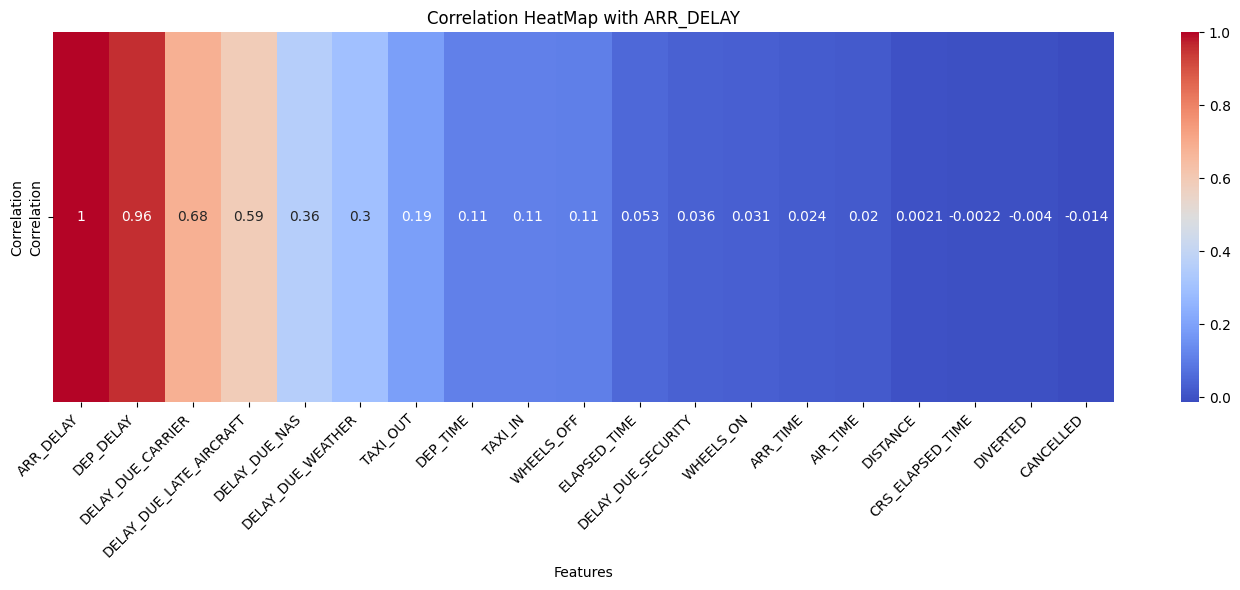

In [4]:
# Plotting of the correlation between ARR_DELAY, our target feature, with others
numeric_cols = [c for c, dtype in dataset_df.dtypes if dtype in ("double")]
correlations = {}
for col in numeric_cols:
    correlation = dataset_df.stat.corr("ARR_DELAY", col) if col != "ARR_DELAY" else 1.0
    correlations[col] = correlation

# Step 3: Convertire i dati delle correlazioni in un DataFrame
correlations_df = pd.DataFrame(list(correlations.items()), columns=["Feature", "Correlation"])
correlations_df.sort_values(by="Correlation", ascending=False, inplace=True)

# Step 4: Creare la Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(correlations_df.set_index("Feature").T, annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation HeatMap with ARR_DELAY")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()


Examination of the schema and data types, checking for null or missing values.

Here we can see that some features like DELAY_DUE... has over 80% of null values so even if they have a strong coorelation(of course), they are not usefull for the analysis

In [5]:
#This line checks the null value per column and then normalize them with the total number of rows.
dataset_df.select([(F.count(F.when(F.col(c).isNull(), c)) / F.count("*")).alias(c) for c in dataset_df.columns]).show()

#This line drops the ARR_DELAY and DEP_DELAY rows with value null because it is not needed
cleaned_df = dataset_df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

# This line shows how the the relative number of null values is 0 in the important columns
cleaned_df.select([(F.count(F.when(F.col(c).isNull(), c)) / F.count("*")).alias(c) for c in cleaned_df.columns]).show()


+-------+-------+-----------+------------+--------+---------+------+-----------+----+---------+------------+--------------------+--------------------+--------------------+--------------------+---------+--------+------------+--------------------+--------------------+---------+-----------------+--------+--------------------+--------------------+--------------------+--------+------------------+------------------+------------------+------------------+-----------------------+
|FL_DATE|AIRLINE|AIRLINE_DOT|AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY|DEST|DEST_CITY|CRS_DEP_TIME|            DEP_TIME|           DEP_DELAY|            TAXI_OUT|          WHEELS_OFF|WHEELS_ON| TAXI_IN|CRS_ARR_TIME|            ARR_TIME|           ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|    CRS_ELAPSED_TIME|        ELAPSED_TIME|            AIR_TIME|DISTANCE| DELAY_DUE_CARRIER| DELAY_DUE_WEATHER|     DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+-------+-------+-----------+------------+------

Now It is time to clean all the dataset in order to prepare it for the ML problem.
I thought about 13 features that are relevant:
 - FL_DATE
 - AIRLINE_CODE
 - ORIGIN
 - DEST
 - CRS_DEP_TIME
 - DEP_DELAY
 - WHEELS_ON
 - WHEELS_OFF
 - TAXI_IN
 - TAXI_OUT
 - ARR_DELAY
 - CRS_ELAPSED_TIME
 - DISTANCE


That is because I thought about predicting a flight and some of the features in the dataset cannot be used because they are known when the flight is finished, for example the ELAPSED_TIME that is calculated at the end.

In [6]:
# Names of columns to drop either because they are useless or they have too much null values(Ex. DELAY_DUE_CARRIER, CANCELLATION_CODE)
columns_to_drop = [
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'CANCELLATION_CODE',
    'DIVERTED', 'AIRLINE_DOT', 'AIRLINE', 'DOT_CODE' , 'ORIGIN_CITY', 'DEST_CITY',
    'FL_NUMBER', 'DEP_TIME', 'AIR_TIME','CANCELLED', 'CRS_ARR_TIME',
    'ARR_TIME', 'ELAPSED_TIME'

]

cleaned_df = cleaned_df.drop(*columns_to_drop)

cleaned_df.printSchema()

# Show the number of rows with non null value
valid_counts = cleaned_df.select([
    F.count(F.col(c)).alias(c) for c in cleaned_df.columns
])
valid_counts.show()

cleaned_df.show(5)

root
 |-- FL_DATE: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: long (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)

+-------+------------+-------+-------+------------+---------+--------+----------+---------+-------+---------+----------------+--------+
|FL_DATE|AIRLINE_CODE| ORIGIN|   DEST|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_DELAY|CRS_ELAPSED_TIME|DISTANCE|
+-------+------------+-------+-------+------------+---------+--------+----------+---------+-------+---------+----------------+--------+
|2913802|     2913802|2913802|2913802|     2913802|  29

Now It is time to convert the columns that are string into number with StringIndexer and OneHotEncoder.

In this case we find the features that are more relevant in order to predict the delay. For example:

[Not relevant features]
 - FL_NUMBER is not relevant for delay;
 - ARR_TIME is not available before the end of the flight;

[Relevant features]
 - FL_DATE, AIRLINE_CODE, ORIGIN and DEST are all good indicators of possible delay;
 - DEP_DELAY is very usefull for the entire delay of the flight;

Next it is time for Vectorization of the dataset, the creation of the target column and the split into train and test.
At first the StringIndexer and OneHotEncoder are used on the String fields(categorical_columns).

In [7]:
categorical_columns = ['FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'DEST']

# StringIndexer e OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_SI") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_SI", outputCol=f"{col}_OHE") for col in categorical_columns]

# Pipeline for StringIndexer e OneHotEncoder
pipeline = Pipeline(stages=indexers + encoders)

del_columns = ['FL_DATE', 'AIRLINE_CODE', 'ORIGIN', 'DEST',
               'FL_DATE_SI', 'AIRLINE_CODE_SI', 'ORIGIN_SI', 'DEST_SI']

# Apply the pipeline
cleaned_df = pipeline.fit(cleaned_df).transform(cleaned_df)
cleaned_df = cleaned_df.drop(*del_columns)
cleaned_df.show(5)

+------------+---------+--------+----------+---------+-------+---------+----------------+--------+-------------------+----------------+----------------+----------------+
|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_DELAY|CRS_ELAPSED_TIME|DISTANCE|        FL_DATE_OHE|AIRLINE_CODE_OHE|      ORIGIN_OHE|        DEST_OHE|
+------------+---------+--------+----------+---------+-------+---------+----------------+--------+-------------------+----------------+----------------+----------------+
|        1155|     -4.0|    19.0|    1210.0|   1443.0|    4.0|    -14.0|           186.0|  1065.0| (1703,[371],[1.0])|  (17,[4],[1.0])|(379,[23],[1.0])|(379,[18],[1.0])|
|        2120|     -6.0|     9.0|    2123.0|   2232.0|   38.0|     -5.0|           235.0|  1399.0|(1703,[1028],[1.0])|  (17,[1],[1.0])|(379,[13],[1.0])| (379,[8],[1.0])|
|         954|      6.0|    20.0|    1020.0|   1247.0|    5.0|      0.0|           118.0|   680.0| (1703,[484],[1.0])|  (17,[4],[1.0])| (379,[3],[1.0]

In this section I tried to use both the scaled and not scaled features. I left the code for the scaled ones applied only on the numerical columns and not on the binary column trasformed with OneHotEncoder.

In [8]:
std_col = ['CRS_DEP_TIME', 'DEP_DELAY', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'TAXI_OUT', 'CRS_ELAPSED_TIME', 'DISTANCE']

no_std_col = ['FL_DATE_OHE', 'AIRLINE_CODE_OHE', 'ORIGIN_OHE', 'DEST_OHE']

# Scaling the numerical variables and assemble everything together
"""
std_assembler = VectorAssembler(inputCols=std_col, outputCol="std_features")
standardScaler = StandardScaler(inputCol="std_features", outputCol="std_features_scaled")
no_std_assembler = VectorAssembler(inputCols=no_std_col, outputCol="no_std_features")
assembler = VectorAssembler(inputCols=["no_std_features","std_features_scaled"], outputCol="features_scaled")
pipeline = Pipeline(stages=[
    std_assembler,
    standardScaler,
    no_std_assembler,
    assembler
])
scaled_df = pipeline.fit(cleaned_df).transform(cleaned_df)

# Show the results
scaled_df.select("no_std_features", "std_features", "features_scaled").show(5, truncate=False)
"""

assembler = VectorAssembler(inputCols=std_col + no_std_col, outputCol="features")
assembled_df = assembler.transform(cleaned_df)
assembled_df = assembled_df.withColumn("is_delayed",
                                   F.when(F.col("ARR_DELAY") > 15, 1).otherwise(0))

assembled_df.show(5, truncate=False)

train_data, test_data, _  = assembled_df.randomSplit([0.6, 0.2, 0.2], seed=42)

+------------+---------+--------+----------+---------+-------+---------+----------------+--------+-------------------+----------------+----------------+----------------+--------------------------------------------------------------------------------------------------------------+----------+
|CRS_DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|ARR_DELAY|CRS_ELAPSED_TIME|DISTANCE|FL_DATE_OHE        |AIRLINE_CODE_OHE|ORIGIN_OHE      |DEST_OHE        |features                                                                                                      |is_delayed|
+------------+---------+--------+----------+---------+-------+---------+----------------+--------+-------------------+----------------+----------------+----------------+--------------------------------------------------------------------------------------------------------------+----------+
|1155        |-4.0     |19.0    |1210.0    |1443.0   |4.0    |-14.0    |186.0           |1065.0  |(1703,[371],[1.0]) |(17,[4

Logistic Regression Model, Evaluator, CrossValidator and Training


In [9]:
# Logistic Regression Model Definition
lr = LogisticRegression(labelCol="is_delayed", featuresCol="features")

paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 0.5])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .build())

evaluator = BinaryClassificationEvaluator(labelCol="is_delayed")

cv_lr = CrossValidator(estimator=lr,
                       estimatorParamMaps=paramGrid_lr,
                       evaluator=evaluator,
                       numFolds=2)

# Linear Regression Train
cv_lr_model = cv_lr.fit(train_data)

Linear Regression Test and ROC

In [10]:
# Linear Regression Test
test_predictions = cv_lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="is_delayed", metricName="areaUnderROC")
auc_roc = evaluator.evaluate(test_predictions)

print(f"Area Under the ROC Curve(Logistic Regression): {auc_roc:.4f}")


Area Under the ROC Curve(Logistic Regression): 0.9758


Random Forest Model, Evaluator, CrossValidator and Training

In [ ]:
# Random Forest Model Definition
rf = RandomForestClassifier(labelCol="is_delayed", featuresCol="features")
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 30, 50])
                .addGrid(rf.maxDepth, [4, 6, 8])
                .build())

evaluator = BinaryClassificationEvaluator(labelCol="is_delayed")
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator,
                       numFolds=2)

# Random Forest Train
cv_rf_model = cv_rf.fit(train_data)

Random Forest Test and ROC

In [ ]:
predictions_rf = cv_rf_model.transform(test_data)

auc_roc_rf = evaluator.evaluate(predictions_rf)
print(f"Area Under the ROC Curve (Random Forest): {auc_roc_rf:.4f}")

Analysis of the Best Linear Regression Model and Best Random Forest Model.
Evaluators are:
 - ROC (Binary) tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.
 - Accuracy (Multiclass) measures how often a machine learning model correctly predicts the outcome.
 - Precision (Multiclass) is the quality of a positive prediction made by the model. Precision refers to the number of true positives divided by the total number of positive predictions.
 - Recall (Multiclass) is a metric that measures how often a model correctly identifies positive instances, true positives, from all the actual positive samples in the dataset.
 - F1 (Multiclass) combines precision and recall scores.


In [ ]:
# Logistic Regression Best Model predictions
lr_best_model = cv_lr_model.bestModel
lr_test_predictions = lr_best_model.transform(test_data)

# Random Forest Best Model predictions
rf_best_model = cv_rf_model.bestModel
rf_test_predictions = rf_best_model.transform(test_data)

# Binary Classification Evaluator for AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="is_delayed", metricName="areaUnderROC")

# Multiclass Classification Evaluator for Accuracy, Precision, Recall, F1,
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed", metricName="f1")

# Logistic Regression Metrics
lr_auc = binary_evaluator.evaluate(lr_test_predictions, {binary_evaluator.metricName: "areaUnderROC"})

lr_accuracy = multiclass_evaluator.evaluate(lr_test_predictions, {multiclass_evaluator.metricName: "accuracy"})
lr_precision = multiclass_evaluator.evaluate(lr_test_predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
lr_recall = multiclass_evaluator.evaluate(lr_test_predictions, {multiclass_evaluator.metricName: "weightedRecall"})
lr_f1 = multiclass_evaluator.evaluate(lr_test_predictions, {multiclass_evaluator.metricName: "f1"})

print("Logistic Regression Metrics:")
print(f"- AUC-ROC: {lr_auc:.4f}")
print(f"- Accuracy: {lr_accuracy:.4f}")
print(f"- Precision: {lr_precision:.4f}")
print(f"- Recall: {lr_recall:.4f}")
print(f"- F1-Score: {lr_f1:.4f}")

# Random Forest Metrics
rf_auc = binary_evaluator.evaluate(rf_test_predictions, {binary_evaluator.metricName: "areaUnderROC"})

rf_accuracy = multiclass_evaluator.evaluate(rf_test_predictions, {multiclass_evaluator.metricName: "accuracy"})
rf_precision = multiclass_evaluator.evaluate(rf_test_predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
rf_recall = multiclass_evaluator.evaluate(rf_test_predictions, {multiclass_evaluator.metricName: "weightedRecall"})
rf_f1 = multiclass_evaluator.evaluate(rf_test_predictions, {multiclass_evaluator.metricName: "f1"})

print("Random Forest Metrics")
print(f"- AUC-ROC: {rf_auc:.4f}")
print(f"- Accuracy: {rf_accuracy:.4f}")
print(f"- Precision: {rf_precision:.4f}")
print(f"- Recall: {rf_recall:.4f}")
print(f"- F1-Score: {rf_f1:.4f}")


Confusion Matrix are of the form:

[True Negative, False Positive]

[False Negative, True Positive]

In [ ]:
# Logistic Regression and Random Forest Confusion Matrix
lr_test_results = lr_test_predictions.select("is_delayed", "prediction")
rf_test_results = rf_test_predictions.select("is_delayed", "prediction")

# Cast is_delayed to double
lr_test_predictions = lr_test_predictions.withColumn("is_delayed", (F.col("is_delayed").cast("double")))
rf_test_results = rf_test_results.withColumn("is_delayed", (F.col("is_delayed").cast("double")))

lr_test_rdd = lr_test_predictions.select("is_delayed", "prediction").rdd.map(tuple)
rf_test_rdd = rf_test_results.select("is_delayed", "prediction").rdd.map(tuple)

# Confusion Matrices
lr_confusion_matrix = MulticlassMetrics(lr_test_rdd).confusionMatrix().toArray()
rf_confusion_matrix = MulticlassMetrics(rf_test_rdd).confusionMatrix().toArray()

print("Logistic Regression Confusion Matrix:")
print(lr_confusion_matrix)

print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)

Now It is time to plot the results of the models.

For the ROC curves the Y-axis is the TPR(True Positive Rate) while the X-axis is FPR(False Positive Rate)


In [ ]:
lr_results = lr_test_predictions.select("is_delayed", "probability").toPandas()
lr_results["predicted_prob"] = lr_results["probability"].apply(lambda x: x[1])

# FPR, TPR e AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(lr_results["is_delayed"], lr_results["predicted_prob"])
auc_lr = auc(fpr_lr, tpr_lr)

# Logistic Regression ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {lr_auc:.4f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], 'r--', lw=1.5, label="Random Guess")
plt.title("ROC Curve Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


rf_results = rf_test_predictions.select("is_delayed", "probability").toPandas()
rf_results["predicted_prob"] = rf_results["probability"].apply(lambda x: x[1])

# FPR, TPR e AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(rf_results["is_delayed"], rf_results["predicted_prob"])
auc_rf = auc(fpr_rf, tpr_rf)

# Random Forest ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1.5, label="Random Guess")
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The last section is to calculate the feature importances of the Random Forest Model and plotting the result.

In [ ]:
# Get the feature importances from the best model
importances = rf_best_model.featureImportances
feature_names = ["CRS_DEP_TIME" , "DEP_DELAY", "TAXI_OUT",
                 "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "CRS_ELAPSED_TIME", "DISTANCE"]

# Convert the feature importances to a Pandas DataFrame
importance_df = pd.DataFrame(list(zip(feature_names, importances)), columns=["Feature", "Importance"])

# Sort by importance (from highest to lowest)
feature_importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the result
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()